This notebook serves as a case study for New Yorker.

Maher Nadar.

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rich import inspect
import math
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

# Pricing

Our marketing manager was surveying the willingness to buy one of our fashion items at a certain price. They discovered the demand quantities, i.e. the number of people willing to buy, at various price levels. We have them below in two arrays. 

Assumptions: <br>

- we have endless enough supply to satisfy any demand --> no constraint on the total purchases of the items being sold by 'New Yorker'.
- the demand gathered by the marketing surveys are considered to be the upper bounds of the potential sales, because the 

In [94]:
pricing_df = pd.DataFrame(
    {
        "price": [100, 90, 70, 60, 40, 20, 10],
        "demand": [100, 120, 200, 300, 1200, 2000, 2800],
    }
)

In [95]:
pricing_df["revenue"] = pricing_df.eval(" price * demand ")

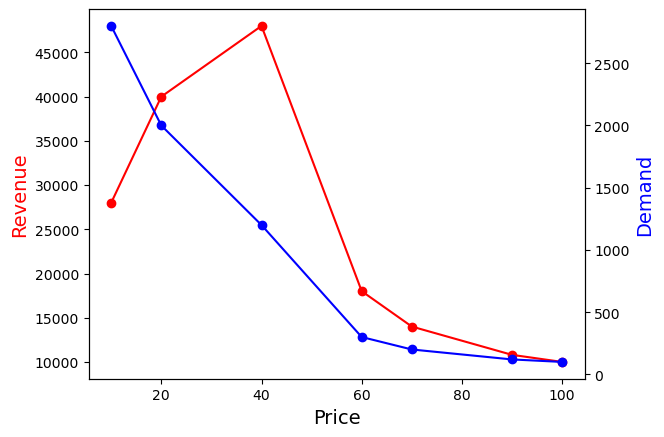

In [96]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots()
# make a plot
ax.plot(
    pricing_df["price"], pricing_df["revenue"], color="red", marker="o", label="Revenue"
)
# set x-axis label
ax.set_xlabel("Price", fontsize=14)
# set y-axis label
ax.set_ylabel("Revenue", color="red", fontsize=14)


ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(
    pricing_df["price"], pricing_df["demand"], color="blue", marker="o", label="Demand"
)
ax2.set_ylabel("Demand", color="blue", fontsize=14)

plt.show()

### Progressive discount price calculation

In [97]:
def calculate_total_cost(demand):
    # Define price tiers and their corresponding quantities
    price_tiers = [(50, 15), (100, 12), (200, 8), (np.inf, 4)]

    total_cost = 0

    # Calculate total cost based on quantity and price tiers
    for tier_quantity, tier_price in price_tiers:
        if demand > tier_quantity:
            total_cost += tier_quantity * tier_price
            demand -= tier_quantity
        else:
            total_cost += demand * tier_price
            break

    return total_cost

In [98]:
pricing_df["cost"] = pricing_df.demand.apply(calculate_total_cost)
pricing_df["profit"] = pricing_df.eval("price * demand - cost")
pricing_df

,price,demand,revenue,cost,profit
0,100,100,10000,1350,8650
1,90,120,10800,1590,9210
2,70,200,14000,2350,11650
3,60,300,18000,3150,14850
4,40,1200,48000,6950,41050
5,20,2000,40000,10150,29850
6,10,2800,28000,13350,14650


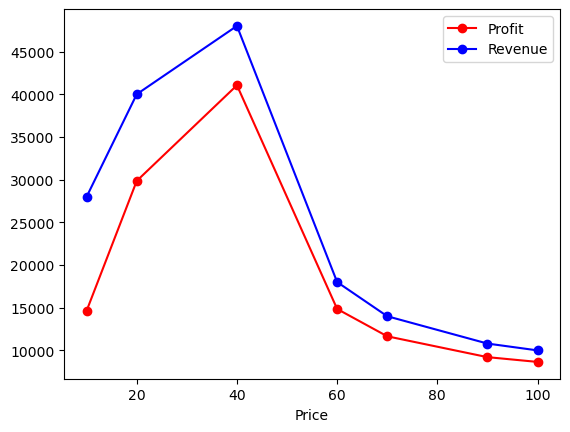

In [99]:
# plot revenue and profit measured data:
plt.plot(
    pricing_df["price"], pricing_df["profit"], color="red", marker="o", label="Profit"
)
plt.plot(
    pricing_df["price"],
    pricing_df["revenue"],
    color="blue",
    marker="o",
    label="Revenue",
)
plt.legend()
plt.xlabel("Price")
plt.show()

## Polynomial fit

### Price optimization based on Revenue

28


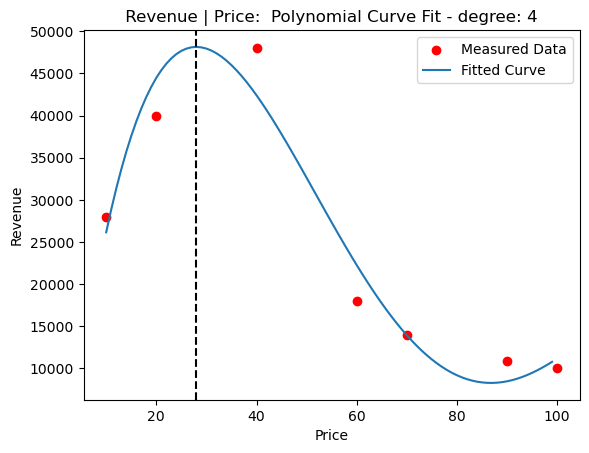

In [100]:
degree = 4

curve_fit = np.polyfit(
    pricing_df["price"].values, pricing_df["revenue"].values, deg=degree
)

x_plot = np.arange(10, 100)
y_plot = np.polyval(curve_fit, x_plot)

plt.scatter(
    pricing_df["price"],
    pricing_df["revenue"],
    color="red",
    marker="o",
    label="Measured Data",
)
plt.plot(x_plot, y_plot, label="Fitted Curve")

plt.title(f" Revenue | Price:  Polynomial Curve Fit - degree: {degree} ")

plt.ylabel("Revenue")
plt.xlabel("Price")
plt.legend()

index = np.argmax(y_plot)
print(x_plot[index])


plt.axvline(x=x_plot[index], color="black", linestyle="--")

plt.show()

#### revenue optimizing function

In [101]:
def revenue_maximizing_price(prices, demand):
    degree = 4

    revenue = prices * demand

    pmin, pmax = prices.min(), prices.max()

    curve_fit = np.polyfit(prices, revenue, deg=degree)
    
    price_space = np.arange(pmin, pmax)
    revenue_space = np.polyval(curve_fit, price_space)

    optimal_price_index = np.argmax(revenue_space)

    return price_space[optimal_price_index]

### Price optimization based on Profit

30


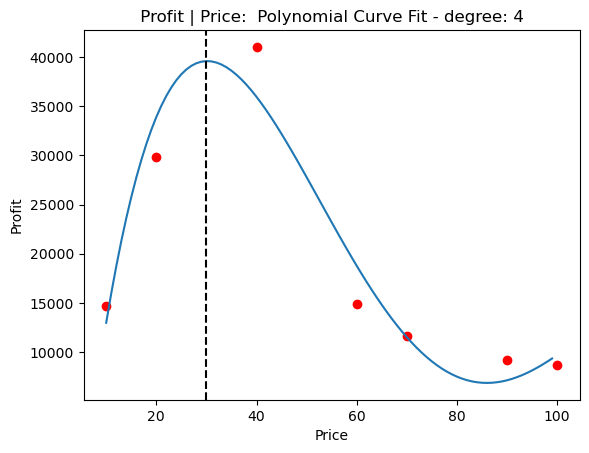

In [102]:
curve_fit = np.polyfit(
    pricing_df["price"].values, pricing_df["profit"].values, deg=degree
)

x_plot = np.arange(10, 100)
y_plot = np.polyval(curve_fit, x_plot)

plt.scatter(
    pricing_df["price"],
    pricing_df["profit"],
    color="red",
    marker="o",
    label="Measured Data",
)
plt.plot(x_plot, y_plot, label="Fitted Curve")

plt.title(f" Profit | Price:  Polynomial Curve Fit - degree: {degree} ")

plt.ylabel("Profit")
plt.xlabel("Price")


index = np.argmax(y_plot)
print(x_plot[index])

plt.axvline(x=x_plot[index], color="black", linestyle="--")

plt.show()

### Profit optimizing function

In [109]:
def profit_maximizing_price(prices, demand):
    degree = 4

    cost = [calculate_total_cost(d) for d in demand]
    
    profit = prices * demand - cost
    
    pmin, pmax = prices.min(), prices.max()

    curve_fit = np.polyfit(prices, profit, deg=degree)
    price_space = np.arange(pmin, pmax)
    profit_space = np.polyval(curve_fit, price_space)

    optimal_price_index = np.argmax(profit_space)

    return price_space[optimal_price_index]

#### Comparing the prices suggested by both optimization methods

In [112]:
profit_optimized_price = profit_maximizing_price(
    prices=pricing_df["price"].values, demand=pricing_df["demand"].values
)
revenue_optimized_price = revenue_maximizing_price(
    prices=pricing_df["price"].values, demand=pricing_df["demand"].values
)

profit_optimized_price, revenue_optimized_price

(30, 28)

According to this technique, it would me advised to price the item in question at 30 € for optimizing on the profit.

If we only had priced based on revenue optimization, the suggested price is 28 €.

## Linear Modeling

Attempt to linearly model the Price and Quantity relation based on the Non-linear demand function: <br>

![Non_linear_demand](data/demand_formula.png)

In [105]:
x_value = np.log(pricing_df.price)
y_value = np.log(pricing_df.demand)
X = add_constant(x_value)
model = sm.OLS(y_value, X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     46.87
Date:                Fri, 01 Dec 2023   Prob (F-statistic):            0.00102
Time:                        17:13:48   Log-Likelihood:                -3.4367
No. Observations:                   7   AIC:                             10.87
Df Residuals:                       5   BIC:                             10.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9628      0.868     13.785      0.0

/Users/man-top/miniconda3/envs/NYRKR/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


The small P values ( <= 0.001 ) indicate that we can reject the null hypothesis that Price does not affect Quantity.

In [106]:
coefficient_pvalue = result.f_pvalue
loga, slope = result.params

Text(0, 0.5, 'Demand')

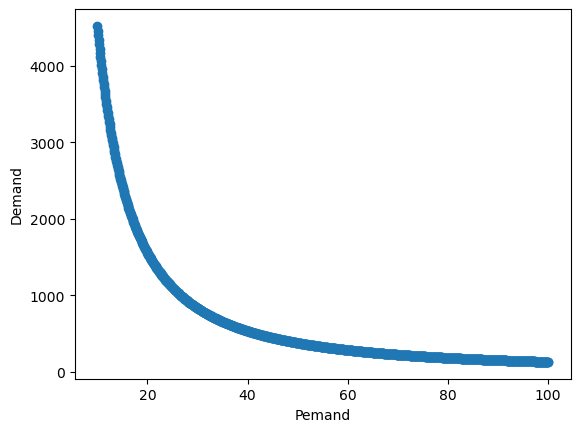

In [107]:
a = round(math.exp(loga), 0)

# Set price range
price = list(np.linspace(10, 100, num=1000))
demand = a * np.power(price, slope)

plt.scatter(x=price, y=demand)
plt.xlabel("Pemand")
plt.ylabel("Demand")

In [108]:
# calculating revenue:
revenue = price * demand

max_revenue = np.max(revenue)
max_index = np.argmax(revenue)

print(
    f" the result of the linear model was to choose the lowest price ({price[max_index]}) "
)

 the result of the linear model was to choose the lowest price (10.0) 
